# Midterm Project 1 - Assignment Details

|  Item | Info.   |
|------|------|
| Group | Antonio Cascio & Krystian Confeiteiro |
| Professor | Dr. Jack |
| Course | DS 440 - 01DB|
| Assignment | Midterm Project 1 ([link](https://erau.instructure.com/courses/163647/assignments/3319745#submit)) |
| Date Created: | 10/10/2023 |
| Date Due: | 10/13/2023 |
| Current Due: | 10/13/2023 |

## Chosen Dataset


# Grading Criteria

| Grading Criteria | Points |
| ---------------------- | --------------------- |
| Show you can train decision tree models with different depths. | 20 pts |
| Show you can use display their confusion matrices of decision trees grown on different depth. | 20 pts |
| Show you can use Occam's Razor critera to evaluate and select the best one. | 20 pts |
| Show you can use dtreeviz library to visualize the structure of decision trees. | 15 pts |
| Show you can use dtreeviz library to display the decision flow of: at least one sample from each class. | 10 pts |
| Your Colab notebook is well organized with sections (5 pts), multiple code blocks (5 pts) and text blocks. | 10 pts |
| Your Colab notebook is not fully executed or with critical runtime errors | -15 pts |

# Assignment Checklist

## Machine Learning
- [X] Show that you can train decision tree models with different depths (20 pts)
- [X] Show you can use display their confusion matrices of decision trees grown on different depth (20 pts)
- [ ] Show that you can use **Occam's Razor critera** to evaluate and select the best one (20 pts)

## Data Visualization
- [X] Show that you can use `dtreeviz` library to visualize the structure of decision trees (15 pts)
- [X] Show that you can use `dtreeviz` library to display the decision flow of: at least one sample from each class (10 pts)


## Colab Notebook Organization & Functionality
- [X] Your Colab notebook is well organized with sections (5 pts)
- [X] Your Colab notebook has multiple code blocks (5 pts)
- [X] Your Colab notebook has text blocks (5 pts)



# Imports

The main libraries used in this project were `pandas` and `sklearn`, for data reading/manipulation and the Decision Tree Classifier, then `dtreeviz` and `graphviz` for visualization of the model.

In [200]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import dtreeviz
import graphviz

from sklearn import tree
from google.colab import drive
from math import log2, floor, ceil
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import (
    cross_val_score,
    train_test_split
)

# ignore warnings & mount Google Drive
warnings.filterwarnings('ignore')
drive.mount('/content/drive/', readonly=True)
ROOT = "/content/drive/MyDrive/006_Courses/DS_440/000_Midterm_Projects/Midterm_1/"
PLOTS = ROOT + "/figures/"


Mounted at /content/drive/


# Helper Functions

These functions serve to assist with the evaluation of the Decision Tree Classifier for miscellaneous purposes.

In [201]:
def fix_data(*data_arr, reshape_size=(1, -1)):
    return (np.array(data).reshape(*reshape_size) for data in data_arr)


def as_np_arr(*data_arrs):
    return (np.array(data) for data in data_arrs)


def replace_vals(data, column, to_replace, replace_with, cfg={"na": False, "case": False, "regex": True}):
    data.loc[data[column].str.contains(to_replace, **cfg) == True, column] = replace_with


def get_uniques(DATA, columns=None):
    _columns = columns if columns else list(DATA.columns)
    return [DATA[col].unique() for col in _columns]


# Decision Tree Classifier Model Function

Here, we define the function, `decision_tree()`, which serves as the main function for the model. Defining it as a model allows for us to easily run new models with differing criteria like **maximum depth**.

In [202]:
def decision_tree(
    X_train,
    X_test,
    y_train,
    y_test,
    feature_names,
    class_names=["0", "1"],
    criterion="entropy",
    random_state=1,
    save_as=None,
    **kwargs
):
    # instantiate & fit model
    MODEL = DecisionTreeClassifier(
        random_state=random_state,
        criterion=criterion,
        **kwargs
    )
    MODEL.fit(X_train, y_train)

    # get train and test prediction values & their accuracies
    pred_train_y = MODEL.predict(X_train)
    pred_test_y = MODEL.predict(X_test)

    training_acc = accuracy_score(y_train, pred_train_y)
    testing_acc = accuracy_score(y_test, pred_test_y)

    print(f"Training accuracy: {training_acc}")
    print(f"Testing accuracy: {testing_acc}")

    # text representation of decision tree
    txt_repr = tree.export_text(MODEL)

    # create decision tree layer outline
    fig = tree.plot_tree(
        MODEL,
        feature_names=feature_names,
        class_names=class_names,
        filled=True
    )

    return training_acc, testing_acc, txt_repr, MODEL, pred_train_y, pred_test_y


# Data Reading & Preparation

## Read Data


In [203]:
# read data
DATA = pd.read_csv(ROOT + "fitness_class_2212.csv")
print("X shape: ", X_vals.shape)
print("y shape: ", y_vals.shape, "\n")


X shape:  (1500, 7)
y shape:  (1500,) 



## Clean & Prepare Data

In order to pass through all the columns (except the `attended` column) through the model, we needed to convert all of the string values and `NaN` values into numerical equvilances. From `REPLACE_1` and `REPLACE_2` we changed the days of the week and categories into their enumerated counterparts.

### Column: `day_of_week`

In [204]:
TARGET_1 = DATA, "day_of_week"
REPLACE_1 = {
    "Sun": 0.0,
    "Moneday|Mon": 1.0,
    "Tue": 2.0,
    "Wednesday|Wed": 3.0,
    "Thu": 4.0,
    "Fri|Fri.": 5.0,
    "Sat": 6.0
}

for key_w, repl in REPLACE_1.items():
    replace_vals(*TARGET_1, key_w, repl)


### Column: `category`

In [205]:
TARGET_2 = DATA, "category"
REPLACE_2 = {
    "-": 0.0,
    "cycling": 1.0,
    "aqua": 2.0,
    "strength": 3.0,
    "hiit": 4.0,
    "yoga": 5.0
}

for key_w, repl in REPLACE_2.items():
    replace_vals(*TARGET_2, key_w, repl)


### Column: `days`

For the `days_before` column, there was no need to convert to number equivalences. The only modifications to the column were the removal of the word "days," as well as stripping any trailing or following spaces.

In [206]:
DATA.days_before = DATA.days_before.apply(lambda x: x.replace(" days", ""))
DATA.days_before = DATA.days_before.apply(lambda x: x.strip())
DATA.days_before = DATA.days_before.astype(int)
SHIT = DATA.days_before


### Column: `time`

Simply displayed below, the `AM` and `PM` values were converted to `0` and `1`, respectively.

In [207]:
TARGET_3 = DATA, "time"
replace_vals(*TARGET_3, "AM", 0)
replace_vals(*TARGET_3, "PM", 1)


## Features & Classes Selection

In [208]:
FEATURES =  DATA.columns.drop("attended")
X_vals, y_vals = DATA[[*FEATURES]], DATA["attended"]
X_vals = X_vals.fillna(0)


# Split Data Into Training & Testing Datasets

In [209]:
DATASETS = train_test_split(X_vals, y_vals, test_size=0.2, stratify=y_vals, random_state=1)
X_train, X_test, y_train, y_test = DATASETS


# First Model Run: `MODEL_1`

Training accuracy: 0.8041666666666667
Testing accuracy: 0.7366666666666667


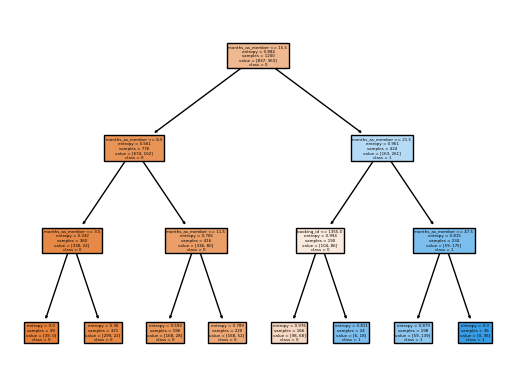

In [210]:
MODEL_1 = decision_tree(
    *DATASETS,
    FEATURES,
    max_depth=3,
)

training_acc1, testing_acc1, txt_repr1, model1, pred_train_y1, pred_test_y1 = MODEL_1


# Model Statistics & Scores

## Classification Report

In [211]:
print(classification_report(y_test, pred_test_y))


              precision    recall  f1-score   support

           0       0.81      0.79      0.80       209
           1       0.55      0.57      0.56        91

    accuracy                           0.73       300
   macro avg       0.68      0.68      0.68       300
weighted avg       0.73      0.73      0.73       300



# Model Visualization

## Visualize Decision Tree with `dtreeviz`

### leaf Distribution & Tree Visualization

In [212]:
viz_1 = dtreeviz.model(
    model1, X_train, y_train,
    feature_names=FEATURES,
    target_name="attended"
)


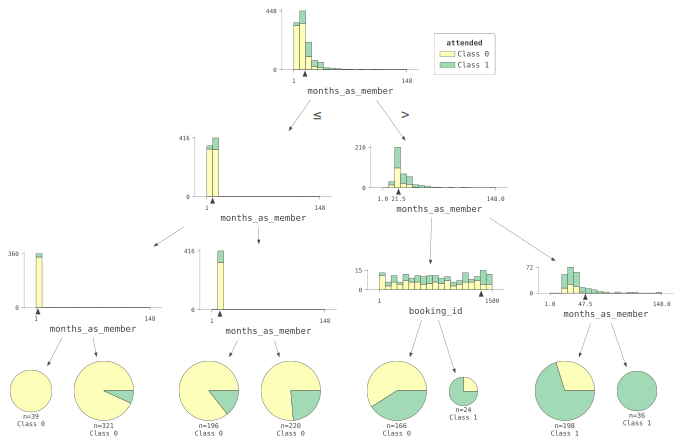

In [213]:
viz_1.view(scale=1.0, fontname="monospace")


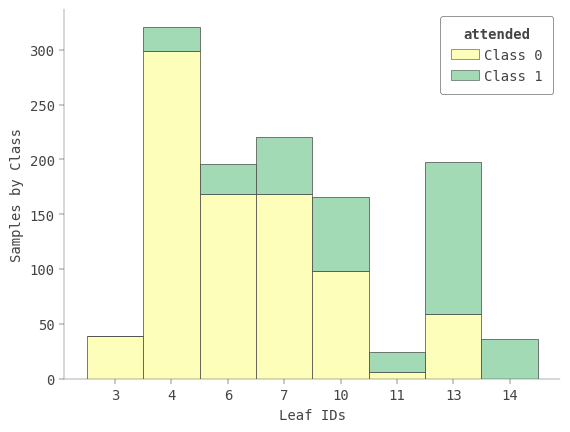

In [214]:
viz_1.ctree_leaf_distributions(fontname="monospace")


### Text Representation for `MODEL_1`

In [215]:
print(txt_repr1)


|--- feature_1 <= 15.50
|   |--- feature_1 <= 8.50
|   |   |--- feature_1 <= 3.50
|   |   |   |--- class: 0
|   |   |--- feature_1 >  3.50
|   |   |   |--- class: 0
|   |--- feature_1 >  8.50
|   |   |--- feature_1 <= 11.50
|   |   |   |--- class: 0
|   |   |--- feature_1 >  11.50
|   |   |   |--- class: 0
|--- feature_1 >  15.50
|   |--- feature_1 <= 21.50
|   |   |--- feature_0 <= 1355.00
|   |   |   |--- class: 0
|   |   |--- feature_0 >  1355.00
|   |   |   |--- class: 1
|   |--- feature_1 >  21.50
|   |   |--- feature_1 <= 47.50
|   |   |   |--- class: 1
|   |   |--- feature_1 >  47.50
|   |   |   |--- class: 1



## Visualization With `graphiz`

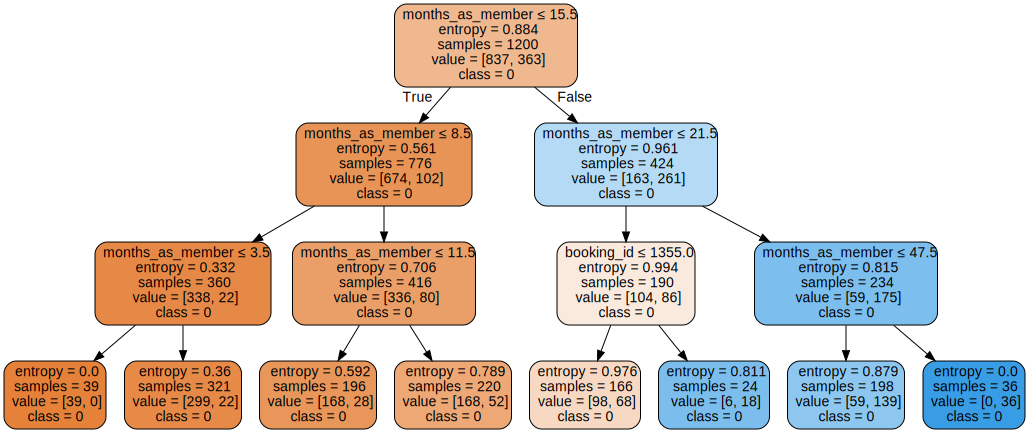

In [216]:
model1_viz = tree.export_graphviz(
    model1,
    out_file=None,
    feature_names=X_train.columns,
    class_names=y_train.astype(str),
    filled=True, rounded=True,
    special_characters=True
)
model1_viz_graph = graphviz.Source(model1_viz)
model1_viz_graph


## Confusion Matrix

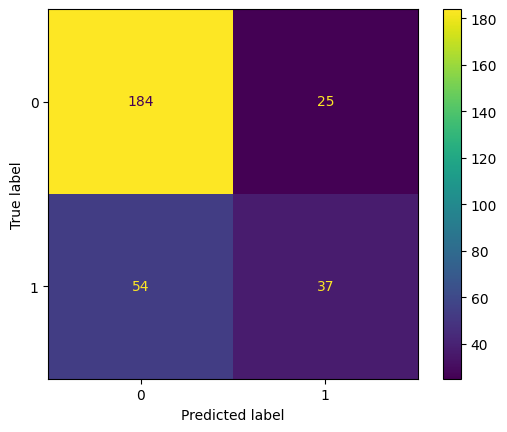

In [217]:
t_n, f_p, f_n, t_p = confusion_matrix(y_test, pred_test_y1).ravel()
conf_mat = confusion_matrix(y_test, pred_test_y1, labels=model1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=model1.classes_)
disp.plot()
plt.show()


# Model Optimization — Minimum Description Length (MDL)

We know, from Aurélien Geron's GitHub repository script on Decision Trees [`06_decision_trees.ipynb`](https://github.com/ageron/handson-ml3/blob/main/06_decision_trees.ipynb), that the depth of the model is proportional to the number of classes;

\begin{equation}
    \text{Depth of Decision Tree} \propto \log_2{(\text{# of instances})}.
\end{equation}

Additionally, from the lecture slides on [Validation and Over-Fitting Problem of Decision Trees](https://erau.instructure.com/courses/163647/files/36009207?module_item_id=10128143), that

\begin{equation}\boxed{
    \text{Total Cost} - \text{Cost}(\text{tree},\text{ data}) = \text{Cost}(\text{tree}) +
    \text{Cost}(\text{data }|\text{ tree})}.
\end{equation}

So, each tree node is determined by the number of attibutes, $m$. If there are five classes, like with our data, then the cost of encoding a class is $\log_2(5)$. $\text{Cost}(\text{data}|\text{tree})$ is evaluated as $\log_2(n)$ bits, where $n$ is the total **number of training instances**.

Summarizing, we have:

- Cost of each **internal node**: $\log_2(m)$ bits.
    \begin{equation}
        m \equiv \text{# of attributes}.
    \end{equation}
- Cost of each **leaf node**: $\log_2(k)$ bits.
    \begin{equation}
        k \equiv \text{# of classes}.
    \end{equation}
- Cost of each **misclassification error**: $\log_2(n)$ bits.
    \begin{equation}
        n \equiv \text{# of training instances} = \text{Max depth}.
    \end{equation}
- Total cost: Add up costs of encoding each **internal node** and each **leaf node**
    \begin{equation}
        \boxed{\text{Total Cost} = \log_2(m) + \log_2(k) = \log_2(km)}.
    \end{equation}
    which I will set to
    \begin{equation}
        \text{Total Cost} \equiv f(k, m),
    \end{equation}
    for simplification.

With these in mind, we can set the values for models. Let this model have four attributes, $m=4$, and five classes, $k=5$, which will both remain contant. What varies, will be the **maximum depth**, $n$. Our three cases will be:

\begin{align}
    \text{Model 1} &\to n_1=5, \\
    \text{Model 2} &\to n_2=10, \\
    \text{Model 3} &\to n_3=15.
\end{align}

The total cost for each of them would be; $f(4,5) = \log_2(20)\approx \boxed{4.322}$.

## Interlude

This last part of this project was the most confusing. We have a lot of collective Python experience, so, the actual coding part was not terribly difficult. We tried to piece this part together using the lecture slides as well as online resources, but could not get the equations to be correct as there were no explicit definitions apart from sparse mentions in our resources.

It is evident, from the previous section, that we were trying to piece everything together, but, could not get further than creating a scenario with three models with the same number of attributes and classes ($m=4$ and $k=5$, respectively), then tried to work through the calculations to determine which model would be the most optimal for the set criteria.
